In [1]:
!pip install pyspark

# Data Exploration


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("BostonHouse").getOrCreate()



In [2]:
df = spark.read.option("header", "true").csv("/content/BostonHousing.csv", inferSchema=True)
df.show()

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

In [3]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [4]:
numeric_columns = list()
categorical_column = list()
for col_ in df.columns:
    if df.select(col_).dtypes[0][1] != "string":
        numeric_columns.append(col_)
    else:
        categorical_column.append(col_)

print("Numeric columns",numeric_columns)
print("categorical columns",categorical_column)

Numeric columns ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']
categorical columns []


# Data Preprocessing

In [5]:
from pyspark.sql.functions import col, sum

null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

null_counts.show()


+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|crim| zn|indus|chas|nox| rm|age|dis|rad|tax|ptratio|  b|lstat|medv|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|   0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+----+



In [6]:
import pyspark.sql.functions as funcs
df.groupBy(df.columns).count().where(funcs.col('count') > 1).select(funcs.sum('count')).show()

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



In [7]:
from pyspark.sql import functions as F

# List of feature columns (exclude target)
target_column = "medv"
feature_cols = [c for c in df.columns if c != target_column]

# Filter outliers column by column
for column in feature_cols:
    stats = df.select(
        F.mean(column).alias("mean"),
        F.stddev(column).alias("std")
    ).collect()[0]

    mean = stats["mean"]
    std = stats["std"]

    if std is not None:  # skip constant columns
        lower = mean - 3 * std
        upper = mean + 3 * std

        df = df.filter(
            (F.col(column) >= lower) & (F.col(column) <= upper)
        )

# Check the result
print(f"Number of rows after outlier removal: {df.count()}")
df.show(5)


Number of rows after outlier removal: 412
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows


# MultiLinear Regression

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

data = assembler.transform(df)
final_data = data.select("features", "MEDV")


In [9]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


In [10]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features",labelCol="MEDV")

lr_model = lr.fit(train_data)


In [11]:
predictions = lr_model.transform(test_data)
predictions.select("medv", "prediction").show(10)


+----+------------------+
|MEDV|        prediction|
+----+------------------+
|32.7| 30.90875969746415|
|24.5|25.592229655433172|
|20.1|18.924081906215957|
|21.6|24.936780693770576|
|31.2| 27.74611494200873|
|34.9|32.090298860921706|
|22.9| 23.65953642745698|
|20.7| 22.86838732684604|
|20.5|22.965510355751267|
|19.4|21.586298608839634|
+----+------------------+
only showing top 10 rows


In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="MEDV",predictionCol="prediction",metricName="rmse")

evaluator_r2 = RegressionEvaluator(
    labelCol="MEDV",
    predictionCol="prediction",
    metricName="r2"
)

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 5.134721528432105
R²: 0.5533504896636594


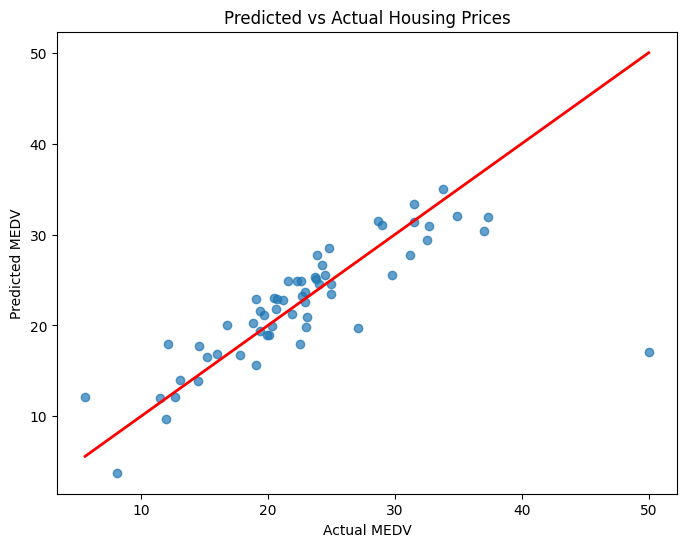

In [13]:
import matplotlib.pyplot as plt
pred_pdf = predictions.select("MEDV", "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(pred_pdf["MEDV"], pred_pdf["prediction"], alpha=0.7)
plt.plot([pred_pdf["MEDV"].min(), pred_pdf["MEDV"].max()],
         [pred_pdf["MEDV"].min(), pred_pdf["MEDV"].max()],
         color='red', linewidth=2)  # diagonal line
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Predicted vs Actual Housing Prices")
plt.show()


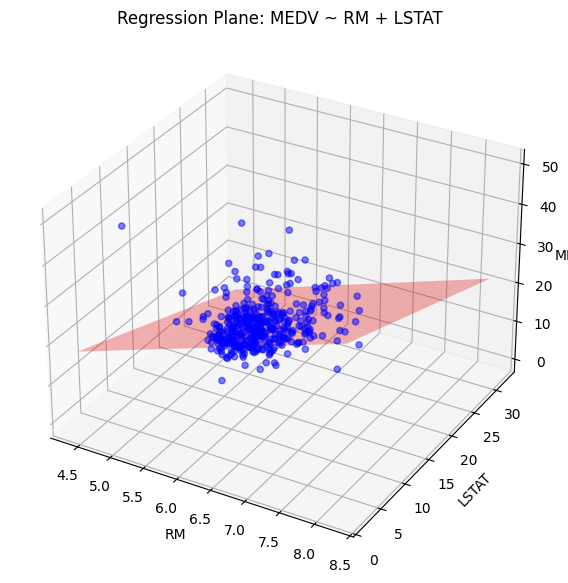

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 1️⃣ Select only RM, LSTAT, and MEDV
selected = df.select("rm", "lstat", "medv").toPandas()
X1 = selected["rm"]
X2 = selected["lstat"]
Y = selected["medv"]

# 2️⃣ Fit Multiple Linear Regression with these 2 features (to get coefficients)
from sklearn.linear_model import LinearRegression

X = selected[["rm","lstat"]].values
y = selected["medv"].values
lr = LinearRegression()
lr.fit(X, y)

# Coefficients from the model
intercept = lr.intercept_
coef_rm, coef_lstat = lr.coef_

# 3️⃣ Create grid for regression plane
x1_grid, x2_grid = np.meshgrid(
    np.linspace(X1.min(), X1.max(), 20),
    np.linspace(X2.min(), X2.max(), 20)
)
y_grid = intercept + coef_rm*x1_grid + coef_lstat*x2_grid

# 4️⃣ Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, color='blue', alpha=0.5, label='Actual')
ax.plot_surface(x1_grid, x2_grid, y_grid, color='red', alpha=0.3, label='Regression Plane')
ax.set_xlabel('RM')
ax.set_ylabel('LSTAT')
ax.set_zlabel('MEDV')
plt.title("Regression Plane: MEDV ~ RM + LSTAT")
plt.show()
